<a href="https://www.kaggle.com/code/peremartramanonellas/guide-tweet-analysis-with-transfer-learning?scriptVersionId=106389843" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    horizontal-align: middle;
}
h1 {
    text-align: center;
    background-color: AliceBlue;
    padding: 10px;
    margin: 0;
    font-family: monospace;
    color:DimGray;
    border-radius: 10px
}

h2 {
    text-align: center;
    background-color: HoneyDew;
    padding: 10px;
    margin: 0;
    font-family: monospace;
    color:DimGray;
    border-radius: 10px
}

h3 {
    text-align: center;
    background-color: MintCream;
    padding: 10px;
    margin: 0;
    font-family: monospace;
    color:DimGray;
    border-radius: 10px
}


body, p {
    font-family: monospace;
    font-size: 15px;
    color: charcoal;
}
div {
    font-size: 14px;
    margin: 0;

}

h4 {
    padding: 0px;
    margin: 0;
    font-family: monospace;
    color: purple;
}
</style>
""")

# A solution to Disaster Twets using Transfer Learning 

In this notebook we are going to solve the Geetting Started competition, Natural Language Processing with Disaster Tweets, using Transfer Learning. 

We will use the Universal Sentence Encoder from Tensorflow Hub. 
https://tfhub.dev/google/universal-sentence-encoder/4

One of the main advantatges of use this model is that we don't need to conver our sentences in embedding, create dictionaris, tokenize.... we avoid a lot of the preprocessment related with NLP. 

We are going to do a minimal treatmet to transform the tweets from: 

- **'.@WestmdCountyPA land bank targets first #Latrobe building in 20th property acquisition to fight #blight: http://t.co/regDv873Aj'**

to 

- **'land bank targets first latrobe building 20th property acquisition fight blight '**

But if you want you can fork the notebook and try to pass the tweets without any transformation. *Most ideas, at the end oh the notebook in the **FORK & IMPROVE** section.*

To achieve this it's necessary to do the next transformations: 

- Remove Marks: Remove punctuactions, and symbols. 
- Tokenize the sentence: Get all words, we are going to use *TweetTokenizer* from the *NLTK* library that have some intelligence adapted to tweets. 
- Remove Stop Words: Downloading the english lybrary *stopwords* from NLTK. We remove a lot of words from the tweets. In the sample above we removed: *in, to*.


In [2]:
#import libraries. 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
#Tranfer learning from tensorhub
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

import re
import string

# Load & Transform the data

In [3]:
train = pd.read_csv("../input/nlp-getting-started/train.csv")
test = pd.read_csv("../input/nlp-getting-started/test.csv")
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


We are going to use only the columns *text* and *target* but it's not necessary to drop the other columns, I want to mantain the notebook as simple as possible. 

In [4]:
calm, disaster = train['target'].value_counts()
calm, disaster

(4342, 3271)

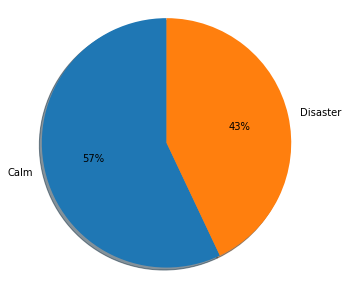

In [5]:
fig = plt.figure(figsize=(5,5))
labels = 'Calm', 'Disaster'
sizes = [calm, disaster]
plt.pie(sizes, labels=labels, autopct='%0.0f%%',
        shadow=True, startangle=90)
plt.axis('equal')
plt.show()

As we can see the datase is well balanced. That's all the EDA I'm going to do.
## Functions to tranform the sentences

In [6]:
#Remove special Tweets characters. 
def remove_marks(sentence):
    sentence_r = re.sub(r'^RT[\s]+', '', sentence)
    sentence_r = re.sub(r'https?://[^\s\n\r]+', '', sentence_r)
    sentence_r = re.sub(r'#', '', sentence_r)
    
    return sentence_r

In [7]:
#Transform each sentence in a list of words. 
TOKENIZER = TweetTokenizer(preserve_case=False, strip_handles=True, 
                              reduce_len=True)

def tokenize(sentence):     
    sentence_tokens = TOKENIZER.tokenize(sentence)
    return sentence_tokens

In [8]:
#remove stopwords and punctuation
nltk.download('stopwords')
STOPWORDS = stopwords.words('english')

def remove_stop_words(sentence_tokenized): 
    no_stop_words = []
    for word in sentence_tokenized:
        if ((word not in STOPWORDS) and (word not in string.punctuation)): 
            no_stop_words.append(word)
    return no_stop_words

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
#Convert list of words in a sentence again. 
def words_to_sentence(list_words):
    sentence = ''
    for word in list_words:
        sentence = sentence + word + ' '
    return sentence

In [10]:
#Call this function to fully transform a sentence. 
def prepare_sentence(sentence):
    sentence_nomarks = remove_marks(sentence)
    sentence_tokenized = tokenize(sentence_nomarks)
    sentence_ready = remove_stop_words(sentence_tokenized)
    sentence_treated = words_to_sentence(sentence_ready)
    return sentence_treated

In [11]:
#testing with one tweet
tweet = train['text'][1234]
tweet

'Fire destroys two buildings on 2nd Street in #Manchester http://t.co/Tqh5amoknd'

In [12]:
tweet_ready = prepare_sentence(tweet)
print(tweet_ready)

fire destroys two buildings 2nd street manchester 


In [13]:
#Transform all tweets
train['text'] = train.apply(lambda row : prepare_sentence(row['text']), axis=1)
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,"13,000 people receive wildfires evacuation ord...",1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


# The Model

I use this function *plot_los_acc* to print the loss and accuracy curve of the models after training. 

You can pass in the parameter *firstepoch* the epoch where the plot starts. Is useful in long training because sometimes is dificult to aprrecite the curve of the plot because of the big improvements in the first epochs. 


In [14]:
#prints loss and accuracy curves. You can indicate first epoch to plot. 
def plot_loss_acc(history, firstepoch=0):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  acc = acc[firstepoch:]
  val_acc = history.history['val_accuracy']
    
  val_acc = val_acc[firstepoch:]
  loss = history.history['loss']
  loss=loss[firstepoch:]
  val_loss = history.history['val_loss']
  val_loss = val_loss[firstepoch:]

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo-', label='Training accuracy')
  plt.plot(epochs, val_acc, 'go-', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo-', label='Training Loss')
  plt.plot(epochs, val_loss, 'go-', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

Time to import the model from TensorFlow Hub. 

I'm indicating in the *trainable* parameter that I don't want to train the model, I preffer to use the weigths of the model. 

But if you want, you can test importing the model with *trainable* to **True**. You will see that the train process is much more slower, and i think that we are not going to get any advantatge. 

It's a really big model and we have just a few data, for sure that we will get a lot of overfitting if we try to train the model with our tweets. But... try it! 

In [15]:
model_hub_path = "https://tfhub.dev/google/universal-sentence-encoder/4"
use_layer = hub.KerasLayer(model_hub_path,
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights. 
                                        name="USE")

2022-09-23 22:50:35.432319: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-23 22:50:35.543466: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-23 22:50:35.544375: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-23 22:50:35.545825: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [16]:
#Split twets and targets in train and validation. 20% in validation. 
tweets = train['text']
targets = train['target']
train_tweets , val_tweets , train_targets, val_targets = train_test_split(tweets.to_numpy(), 
                                                                          targets.to_numpy(), 
                                                                          test_size=0.2, random_state=42)
print(train_tweets[1:10]) 

['wld b shame golf cart became engulfed flames boycottbears '
 'tell rescind medals honor given us soldiers massacre wounded knee sign rt '
 'worried ca drought might affect extreme weather dampen economy '
 'lava blast power red pantherattack '
 'wreckage conclusively confirmed mh370 malaysia pm investigators families ... '
 'builder dental emergency ruined plan emotionally blackmail afternoon bump '
 'bmx issues areal flood advisory shelby al till aug 5 9:00 pm cdt '
 "360wisenews china's stock market crash gems rubble "
 'getting hit foul ball sitting hardly freak accident war zone ']


## Callback Functions

I'm going to define 2 callback functions. One to save the model with the best accuracy, and the other to reduce the learning rate if the model don't improve the accuracy en 'n' epochs. 

In [17]:
SaveModel = tf.keras.callbacks.ModelCheckpoint('BMTLTweet.h5', 
                                           mode='auto', monitor='val_accuracy', 
                                           verbose=1, 
                                           save_best_only=True)

In [18]:
#reduce in 0.1 the learning rate when we got 3 consecutive epochs without 
#improvements in the val_accuracy. 
ReduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,
                              patience=3, verbose=1, mode='auto', min_lr=0.0001)

In [19]:
tf.keras.backend.clear_session()

## Join the Pretrained Model with our Specific Layers 

Now we can create a sequential Model and indicate that the first layer is the model downloaded. 

The rest of the layers are the trainable layer that we can train with our Data. 

I decided to use 2 Dense layers with 128 Nodes and 2 dropoout layers in order to reduce the overfitting. 

In [20]:
modeltl0 = tf.keras.Sequential()
modeltl0.add(use_layer)
modeltl0.add(tf.keras.layers.Dropout(0.4))
modeltl0.add(tf.keras.layers.Dense(128,activation='relu'))
modeltl0.add(tf.keras.layers.Dropout(0.4))
modeltl0.add(tf.keras.layers.Dense(128,activation='relu'))
modeltl0.add(tf.keras.layers.Dense(1, activation ='sigmoid'))
modeltl0.compile(loss= "binary_crossentropy", optimizer = 'adam',metrics=["accuracy"])
modeltl0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 256,880,129
Trainable params: 82,305
Non-trainable params: 256,797,824
_____________________________________

As you can see in the summary we have a total of **256,880,129** parameters but only **82,305** of the are trainables. 


In [21]:
historytl0 = modeltl0.fit(train_tweets, train_targets, epochs=15, 
                          validation_data=(val_tweets, val_targets), 
                         callbacks=[SaveModel, ReduceLR])

Epoch 1/15
191/191 [==============================] - 6s 15ms/step - loss: 0.5319 - accuracy: 0.7422 - val_loss: 0.4363 - val_accuracy: 0.7984

Epoch 00001: val_accuracy improved from -inf to 0.79842, saving model to BMTLTweet.h5
Epoch 2/15
191/191 [==============================] - 2s 12ms/step - loss: 0.4486 - accuracy: 0.7966 - val_loss: 0.4249 - val_accuracy: 0.8024

Epoch 00002: val_accuracy improved from 0.79842 to 0.80236, saving model to BMTLTweet.h5
Epoch 3/15
191/191 [==============================] - 3s 13ms/step - loss: 0.4325 - accuracy: 0.8046 - val_loss: 0.4225 - val_accuracy: 0.8155

Epoch 00003: val_accuracy improved from 0.80236 to 0.81550, saving model to BMTLTweet.h5
Epoch 4/15
191/191 [==============================] - 2s 12ms/step - loss: 0.4210 - accuracy: 0.8130 - val_loss: 0.4239 - val_accuracy: 0.8096

Epoch 00004: val_accuracy did not improve from 0.81550
Epoch 5/15
191/191 [==============================] - 2s 13ms/step - loss: 0.4172 - accuracy: 0.8092 - va

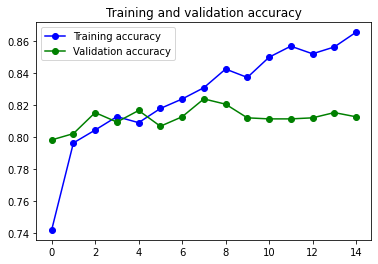

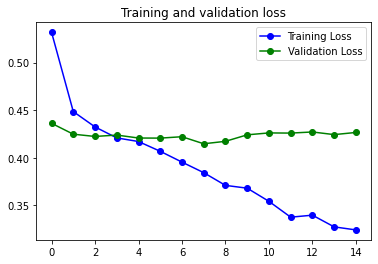

In [22]:
plot_loss_acc(historytl0)

The best result, with this combnination of Dense and Dropout layers is obtained in the first epochs. The best model is saved in the file *BMTLTweet.h5*  thanks to one  of the callbacks functions. 

### Getting predictions & send results

In [23]:
#Load the best model stored
bestModel = tf.keras.models.load_model('BMTLTweet.h5', custom_objects={'KerasLayer': hub.KerasLayer})

In [24]:
#check the test tweets. 
test['text'][350]

'.@WestmdCountyPA land bank targets first #Latrobe building in 20th property acquisition to fight #blight: http://t.co/regDv873Aj'

In [25]:
#Transform each test tweet and check the result
testweets = test.apply(lambda row : prepare_sentence(row['text']), axis=1)
testweets[350]

'land bank targets first latrobe building 20th property acquisition fight blight '

In [26]:
results = bestModel.predict(testweets)

In [27]:
#Create a Dataframe with the 'id' and 'target' columns
final = pd.DataFrame()
final['id'] = test['id']
final.head()
final['target'] = results
final['target'] = final['target'].apply(lambda x:1 if x>0.5 else 0)
final.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1


In [28]:
#file to submit
final.to_csv('./submission.csv', index=False)

# Conclusions, Fork & improve. 
Yeah! The score of this notebook is 0.813.... not bad at all! Is realy good. 

We did a little effort to obtain this score, is a simple notebook, where we just did a simple transformation of the tweets (but I think that we can just don't do it). We imported a amazing model from tensorflow hub, add some really simple layers... and that's all!!!!! 

If you want you can Fork and try to improve this score, you can do a lot of research and experiments.

- Don't transform the tweets. 
- Maybe don't use stop words. 
- Change the layers. Why two dense layers? Try with One. Reduce or increase the nodes (try with just two layers of 8 nodes). 
- Reduce, Increase the dropout. 
- Import the model as Trainable, and train it with the tweets. 
- Change the Callback functio to monitorize the Val_loss instead val_accuracy. 

Please, if you improve the results, let me know in the comments! I will be really happy to discuss the results, and of course upvote your notebook. 

If you like the notebook, considere to **upvote it!** I will be really happy and it encourage me a lot to share more notebooks. 

# Inspirations. 
For sure that there must be a lot of similar notebooks in this competition, but my main inspiration comes from TensorFlow Developer Specialization that I coursed in Coursera. 

Now I'm doing a serie of notebooks related to NLP. This is the second one, if you are interested in more notebooks about NLP, with more advanced techniques, just consider to follow me, or check my profile. 

May the Transfer Learning be with you. 
